In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
%matplotlib inline
from qiskit import Aer
from qiskit import execute
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer
from qiskit import IBMQ
from qiskit import compile
from qiskit.tools.visualization import plot_histogram

my_style = {'cregbundle': True}

In this notebook, we will try to implement Shor's algorithm for a simple example using Qiskit. Shor's algorithm applies to composite numbers M which are odd and not a prime power. So the smallest meaningful example is M=15.

In our implementation, we will actually cheat - we will use knowledge about the factors of M at some points that we would not have for a real example with a large integer M. 

To start, let us recall that the algorithm picks a number a relatively prime to M and calculates the period of a module M. We will use a = 11. Let us manually determine its period first.

In [2]:
M = 15
a = 11
print("a**2: ", a*a % M)


a**2:  1


Thus the period r is two. How would we find the period using a quantum circuit? For our implementation, it turns out to be most useful to describe Shor's algorithm in terms of the quantum phase estimation. In this description, we apply the quantum phase estimation algorithm to the state $|1 \rangle$. So let us see how a circuit for this QPE looks like.

We start with a very simple version - a one-qubit QPE. Recall that in the QPE algorithm relevant for period finding, we have a primary register p holding the initial state - $|1 \rangle$ in our case - and an working register w with t qubits (in our case, we start with t = 1). The circuit acts with a Hadamard on each qubit of the working register and prepares the primary register in the state $|1 \rangle$. We then apply a sequence of t controlled $U^k$ operations, where $U$ is the unitary operator on the primary register given by multiplication with a, i.e. 
$$
|x \rangle \mapsto |a x \rangle
$$
Thus the first thing that we need is a circuit implementing this controlled operation. However, we are lucky - we only need to implement this for the input $|1 \rangle$. Then the result is $|11 \rangle$, and our resulting circuit is very simple - we simply need to toggle qubits 1 and 3 conditional on the working register

In [3]:
def oneQbitCircuit(p, w, c):
    circuit = QuantumCircuit(w,p, c)
    # Prepare initial state 1 in primary register
    circuit.x(p[0])
    circuit.barrier(p)
    circuit.barrier(w)
    
    # Add Hadamard gate to working register
    circuit.h(w[0])
    # Add conditional multiplication by a to primary register
    circuit.cx(w[0], p[1])
    circuit.cx(w[0], p[3])
    return circuit

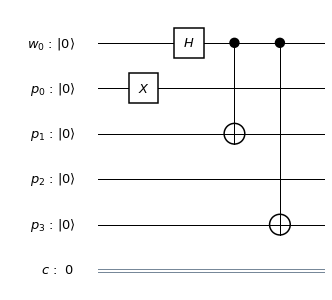

In [4]:
p = QuantumRegister(4,"p")
w = QuantumRegister(1,"w")
c = ClassicalRegister(1, "c")
circuit = oneQbitCircuit(p,w,c)
drawer(circuit, style=my_style)

Let us see what state we expect here. According to the general logic of the QPE circuit, we should be in the state
$$
\frac{1}{\sqrt{2}} \sum_{s=0}^1 |a^s \rangle |s \rangle  =\frac{1}{\sqrt{2}} (  |1 \rangle |0\rangle + 
|11\rangle) |1 \rangle  = \frac{1}{\sqrt{2}} ( |2 \rangle + 
|23\rangle) 
$$
Here we follow the Qiskit convention and write the primary register first, yielding the most significant bits. Let us test this using the state vector simulator.

In [5]:
backend = Aer.get_backend('statevector_simulator') 
job = execute(circuit, backend)
job.result().get_statevector()

array([ 0.00000000+0.j,  0.00000000+0.j,  0.70710678+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.70710678+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,
        0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j])

Nice, this is what we expected. Let us now see how we can extend this to two qubits. For that purpose, we need to add a conditional version of $a^2$. But this is trivial, as $a^2$ is already 1 module 15. So our two-qubit circuit is simply the same as the one qubit circuit, with one additional working qubit.

In [6]:
def twoQbitCircuit(p, w, c):
    circuit = QuantumCircuit(w,p, c)
    # Prepare initial state 1 in primary register
    circuit.x(p[0])
    circuit.barrier(p)
    circuit.barrier(w)
    
    # Add Hadamard gate to working register
    circuit.h(w[0])
    circuit.h(w[1])
    # Add conditional multiplication by a to primary register
    circuit.cx(w[0], p[1])
    circuit.cx(w[0], p[3])
    return circuit

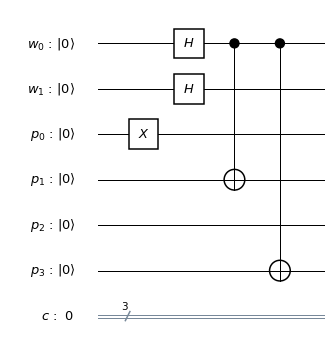

In [7]:
p = QuantumRegister(4,"p")
w = QuantumRegister(2,"w")
c = ClassicalRegister(3, "c")
circuit = twoQbitCircuit(p,w,c)
drawer(circuit, style=my_style)

Let us again test this. We expect the following four basis vectors to show up
$$
|1\rangle |0 \rangle = |4\rangle
$$
$$
|11\rangle |1 \rangle = |45\rangle
$$
$$
|1\rangle |2 \rangle = |6\rangle
$$
$$
|11\rangle |3 \rangle = |47\rangle
$$


In [8]:
backend = Aer.get_backend('statevector_simulator') 
job = execute(circuit, backend)
state = np.around(job.result().get_statevector(), 2)
for i in range(2**6):
    if (state[i] != 0):
        print("|",i,"> ---> ", state[i])

| 4 > --->  (0.5+0j)
| 6 > --->  (0.5+0j)
| 45 > --->  (0.5+0j)
| 47 > --->  (0.5+0j)


Finally, the last circuit we need is multiplication by $a^4$ modulo 15. But this is again one, so the circuit is the identity. Therefore our three qubit circuit is identical to our two qubit circuit, just with one more qubit in the working register. 

In [9]:
def threeQbitCircuit(p, w, c):
    circuit = QuantumCircuit(w,p, c)
    # Prepare initial state 1 in primary register
    circuit.x(p[0])
    circuit.barrier(p)
    circuit.barrier(w)
    
    # Add Hadamard gates to working register
    circuit.h(w[0])
    circuit.h(w[1])
    circuit.h(w[2])
    # Add conditional multiplication by a to primary register
    circuit.cx(w[0], p[1])
    circuit.cx(w[0], p[3])
    return circuit

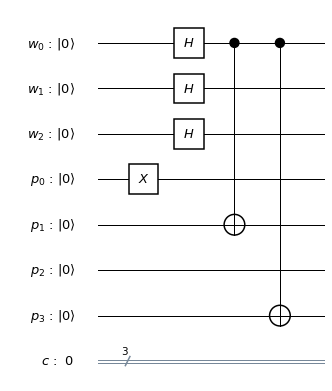

In [10]:
p = QuantumRegister(4,"p")
w = QuantumRegister(3,"w")
c = ClassicalRegister(3, "c")
circuit = threeQbitCircuit(p,w,c)
drawer(circuit, style=my_style)

In [11]:
#
# Print out expected amplitudes up to normalisation
# 
for s in range(2**3):
    x = a**s % 15
    print("|", x*8 + s, "> = |",x,">|", s,">")

| 8 > = | 1 >| 0 >
| 89 > = | 11 >| 1 >
| 10 > = | 1 >| 2 >
| 91 > = | 11 >| 3 >
| 12 > = | 1 >| 4 >
| 93 > = | 11 >| 5 >
| 14 > = | 1 >| 6 >
| 95 > = | 11 >| 7 >


In [12]:
backend = Aer.get_backend('statevector_simulator') 
job = execute(circuit, backend)
state = np.around(job.result().get_statevector(), 2)
for i in range(2**7):
    if (state[i] != 0):
        print("|",i,"> = |", i // 8, ">|", i % 8,"> ---> ", state[i])

| 8 > = | 1 >| 0 > --->  (0.35+0j)
| 10 > = | 1 >| 2 > --->  (0.35+0j)
| 12 > = | 1 >| 4 > --->  (0.35+0j)
| 14 > = | 1 >| 6 > --->  (0.35+0j)
| 89 > = | 11 >| 1 > --->  (0.35+0j)
| 91 > = | 11 >| 3 > --->  (0.35+0j)
| 93 > = | 11 >| 5 > --->  (0.35+0j)
| 95 > = | 11 >| 7 > --->  (0.35+0j)


So our circuit seems to work fine. Let us now combine this into one circuit with the QFT and see what we get.

In [13]:
def nBitQFT(q,c,n=3):
    circuit = QuantumCircuit(q,c)
    #
    # We start with the most significant bit
    #
    for k in range(n):
        j = n - k
        # Add the Hadamard to qubit j-1
        circuit.h(q[j-1])
        #
        # there is one conditional rotation for
        # each qubit with lower significance
        for i in reversed(range(j-1)):
            circuit.cu1(2*np.pi/2**(j-i),q[i], q[j-1])
    #
    # Finally we need to swap qubits
    #
    for i in range(n//2):
        circuit.swap(q[i], q[n-i-1])
    return circuit

In [14]:
circuit = threeQbitCircuit(p,w,c) + nBitQFT(w,c,n=3)
circuit.barrier(w)
circuit.measure(w,c)

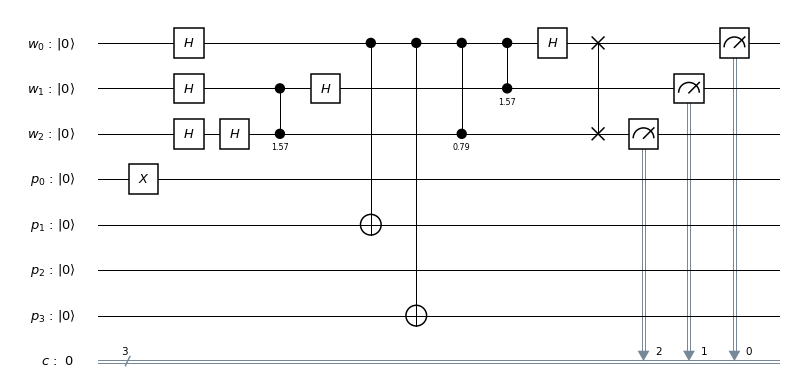

In [15]:
drawer(circuit, style=my_style)

Before we run this, let us try to understand what output we expect. The value in the working register after a measurement will be a multiple or $2^n$ / r. In our case, r=2 and n=3, so the output is a multiple of four. Thus we expect peaks at 000 and 100. Let us see whether this is what we get.

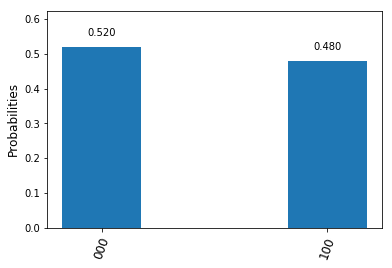

In [16]:
backend = Aer.get_backend('qasm_simulator') 
job = execute(circuit, backend)
counts = job.result().get_counts()
plot_histogram(counts)

Before running this on real hardware, let us try to optimize the circuit a bit. For that purpose, we combine the two subcircuits into one function. We can then apply a few optimizations. First, we skip the final swap gates in the QFT circuit - this will change our expected output from 100 to 001, but we can keep track of this manually when setting up the measurement. Next, we have two Hadamard gates on w[2] that cancel at that we can therefore remove. And the Pauli X gate on p[0] is never really used and can be dropped. We then run this once more on the simulator to verify that our circuit still works, and finally do a run on reald hardware.

In [17]:
def shorAlgorithm(n=3):
    # Create registers and circuit
    p = QuantumRegister(4,"p")
    w = QuantumRegister(n,"w")
    c = ClassicalRegister(n, "c")
    circuit = QuantumCircuit(w,p,c)
    # Add Hadamard gates to working register
    circuit.h(w[0])
    circuit.h(w[1])
    # Add conditional multiplication by a to primary register
    circuit.cx(w[0], p[1])
    circuit.cx(w[0], p[3])
    #
    # Now build the QFT part. We start with the most significant bit
    #
    for k in range(n):
        j = n - k
        # Add the Hadamard to qubit j-1
        if (j - 1) != 2:
            circuit.h(w[j-1])
        #
        # there is one conditional rotation for
        # each qubit with lower significance
        for i in reversed(range(j-1)):
            circuit.cu1(2*np.pi/2**(j-i),w[i], w[j-1])
    #
    # and add the measurements
    #
    circuit.barrier(w)
    circuit.measure(w[0],c[2])
    circuit.measure(w[2], c[0])
    circuit.measure(w[1], c[1])
    return circuit

In [18]:
circuit = shorAlgorithm()

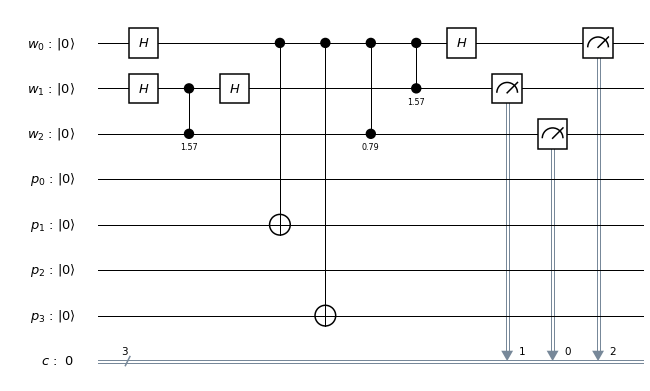

In [19]:
drawer(circuit, style=my_style)

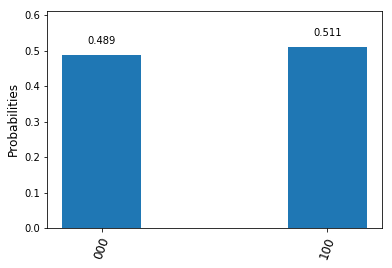

In [20]:
backend = Aer.get_backend('qasm_simulator') 
job = execute(circuit, backend)
counts = job.result().get_counts()
plot_histogram(counts)

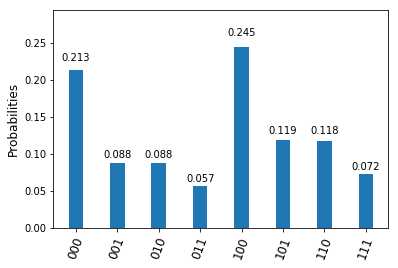

In [21]:
IBMQ.load_accounts()
backend = IBMQ.get_backend('ibmq_16_melbourne') 
job = execute(circuit, backend)
counts = job.result().get_counts()
plot_histogram(counts)